In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot

In [2]:
%matplotlib inline

In [3]:
session = tf.InteractiveSession()

In [4]:
HEIGHT, WIDTH = 150, 200
ASPECT = float(WIDTH) / HEIGHT
LIGHT_DIRECTION = tf.nn.l2_normalize(tf.ones([3]), 0)

grid = np.array(np.meshgrid(np.linspace(-ASPECT, ASPECT, WIDTH), np.linspace(1, -1, HEIGHT)), dtype='float32')
pixel_coordinates = tf.transpose(tf.constant(grid), perm=[1, 2, 0])

In [5]:
def length(position):
    return tf.sqrt(tf.reduce_sum(tf.square(position), 2, keep_dims=True))

In [6]:
import math

In [7]:
angles = pixel_coordinates * tf.constant([math.pi / 2.0 / ASPECT, 3.0 * math.pi / 8.0])
mapped_pixels = -tf.nn.l2_normalize(angles, 2) * tf.log(tf.cos(length(angles)))
# mapped_pixels = pixel_coordinates

In [8]:
pixel_world_coordinates = tf.concat(2, [mapped_pixels, -tf.ones([HEIGHT, WIDTH, 1])])

In [9]:
pixel_rays = tf.nn.l2_normalize(pixel_world_coordinates, 2)

In [10]:
pixel_origins = tf.zeros_like(pixel_rays)

In [11]:
view_position = tf.Variable(tf.constant([0, 0, 10], dtype='float'))

In [12]:
pixel_positions = pixel_origins + view_position

In [13]:
EPSILON = 1e-6

In [14]:
def dot(a, b):
    return tf.reduce_sum(a * b, 2, keep_dims=True)

In [15]:
def repeat(position, spacing, primitive):
    repeat_position = tf.mod(position, spacing) - 0.5 * spacing
    return primitive(repeat_position)

In [16]:
def normal(position, primitive):
    dx = tf.constant([1, 0, 0], dtype='float')
    dy = tf.constant([0, 1, 0], dtype='float')
    dz = tf.constant([0, 0, 1], dtype='float')
    return tf.nn.l2_normalize(tf.concat(2, [
            primitive(position + dx) - primitive(position - dx),
            primitive(position + dy) - primitive(position - dy),
            primitive(position + dz) - primitive(position - dz),
        ]), 2)

In [17]:
def distance_to_sphere(position):
    return length(position) - 1.0

In [18]:
def distance_function(position):
    d = 3.0
    dx = tf.constant([1, 0, 0], dtype='float')
    dy = tf.constant([0, 1, 0], dtype='float')
    return tf.reduce_min(
        tf.concat(2, [
            distance_to_sphere(position - 3.0 * d * dx - d * dy),
            distance_to_sphere(position - 2.0 * d * dx - d * dy),
            distance_to_sphere(position - 1.0 * d * dx - d * dy),
            distance_to_sphere(position - d * dy),
            distance_to_sphere(position + 1.0 * d * dx - d * dy),
            distance_to_sphere(position + 2.0 * d * dx - d * dy),
            distance_to_sphere(position + 3.0 * d * dx - d * dy),
            distance_to_sphere(position - 3.0 * d * dx),
            distance_to_sphere(position - 2.0 * d * dx),
            distance_to_sphere(position - 1.0 * d * dx),
            distance_to_sphere(position),
            distance_to_sphere(position + 1.0 * d * dx),
            distance_to_sphere(position + 2.0 * d * dx),
            distance_to_sphere(position + 3.0 * d * dx),
            distance_to_sphere(position - 3.0 * d * dx + d * dy),
            distance_to_sphere(position - 2.0 * d * dx + d * dy),
            distance_to_sphere(position - 1.0 * d * dx + d * dy),
            distance_to_sphere(position + d * dy),
            distance_to_sphere(position + 1.0 * d * dx + d * dy),
            distance_to_sphere(position + 2.0 * d * dx + d * dy),
            distance_to_sphere(position + 3.0 * d * dx + d * dy),
        ]), 2, keep_dims=True)

In [19]:
for i in range(50):
    distance = distance_function(pixel_positions)
    pixel_positions = pixel_positions + 0.99 * tf.to_float(distance > EPSILON) * distance * pixel_rays

In [20]:
normals = normal(pixel_positions, distance_function)

In [21]:
color = tf.to_float(distance >= EPSILON) * 0.5 * tf.ones_like(pixel_positions) + tf.to_float(distance < EPSILON) * tf.ones([3]) * (0.9 * tf.nn.relu(dot(normals, LIGHT_DIRECTION)) + 0.1)

In [22]:
jpeg = tf.image.encode_jpeg(tf.image.convert_image_dtype(color, tf.uint8), 'rgb')

In [23]:
session.run(tf.initialize_all_variables())

In [24]:
image, jpeg_data = session.run([color, jpeg])

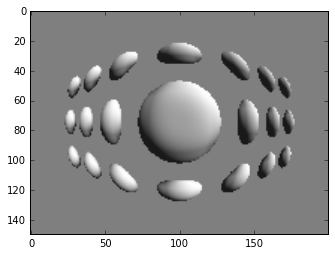

In [25]:
matplotlib.pyplot.imshow(image)

In [26]:
jpeg_file = open('out.jpg', 'w')
jpeg_file.write(jpeg_data)
jpeg_file.close()

TypeError: must be str, not bytes

In [ ]:
unwarped_image = np.zeros_like(image)

In [ ]:
pix_coords = np.transpose(grid, axes=[1, 2, 0])
pix_angles = pix_coords * np.array([math.pi / 3.0 / ASPECT, 3.0 * math.pi / 8.0])

In [ ]:
theta_y = np.linalg.norm(pix_angles, axis=2)[:, :, np.newaxis]
dir_y = pix_angles / theta_y
s_x = np.arccos(np.exp(-np.tan(theta_y)))

In [ ]:
theta_x = np.arctan(s_x)

In [ ]:
x = dir_y * theta_x

In [ ]:
x_coords = x / np.array([math.pi / 4.0, math.pi / 4.0])

In [ ]:
np.min(x_coords[:, :, 0])

In [ ]:
indices = np.floor((x_coords + 1) * np.array([HEIGHT, WIDTH]) / 2.0).astype('int')

In [ ]:
indices = np.maximum(indices, 0)

In [ ]:
for i in range(HEIGHT):
    for j in range(WIDTH):
        unwarped_image[i, j] = image[min(indices[i, j, 0], HEIGHT-1), min(indices[i, j, 1], WIDTH-1)]

In [ ]:
matplotlib.pyplot.imshow(unwarped_image)